# What do we want to look at? (Larger Areas)


In [ ]:
import pandas as pd
import numpy as np
import time,os,sys
from p_tqdm import p_map
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point, Polygon

import sqlite3
sqlite3.register_adapter(np.int64, lambda val: int(val))
sqlite3.register_adapter(np.int32, lambda val: int(val))

from const import DATASETS,SETTINGS

In [ ]:
areas= gpd.read_file('Counties_and_Unitary_Authorities_(December_2020)_UK_BGC.geojson')
areas.head()


In [157]:
# def get_centroids(kind):
areatype = 'Output_Areas'    
if 'Areas' in sys.argv[1]:
    areatype = sys.argv[1]

__outdir__='flatdb/'+areatype
try:os.mkdir(__outdir__)
except:pass

areatype

'Output_Areas'

In [95]:


cdf = pd.DataFrame()
for y in SETTINGS.years:
    f = SETTINGS.matchC(areatype,y)
    print(f)
    dummy = pd.read_csv(f)
    dummy['YEAR'] = y
    # dummy.columns = ['AREACD' if 'cd' in x.lower() else x for x in dummy.columns]
    cdf = pd.concat([cdf, dummy ],axis=0)# df.append(process_df(url,src))

cdf.columns = 'AREACD LAT LON YEAR'.split()
cdf.groupby('AREACD').mean().reset_index()
cdf['GEOGRAPHY_CODE'] = cdf.index
cdf = cdf.astype({'AREACD': str,
            'LAT': np.int32,
            'LON': np.int32,
            'YEAR': np.int32,
            'GEOGRAPHY_CODE': np.int32})

geomap = dict(zip(cdf.AREACD,cdf.GEOGRAPHY_CODE))
cdf


./centroids/WGS84_simplified/Output_Areas__December_2001__Population_Weighted_Centroids.csv
./centroids/WGS84_simplified/Output_Areas__December_2011__Population_Weighted_Centroids.csv


,AREACD,LAT,LON,YEAR,GEOGRAPHY_CODE
0,E00096400,4991255,-635657,2001,0
1,E00096408,4995521,-633513,2001,1
2,E00096403,4991416,-631972,2001,2
3,E00096407,4991482,-631683,2001,3
4,E00096405,4991448,-631232,2001,4
...,...,...,...,...,...
181403,E00154294,5248530,175406,2011,181403
181404,E00154282,5248185,175461,2011,181404
181405,E00154272,5248384,175520,2011,181405
181406,E00154271,5248634,175582,2011,181406


In [97]:

pts = [Point(p[1].LON/1e5,p[1].LAT/1e5) for p in list(cdf.iterrows())]
cdf['pts'] = pts

In [98]:
# cdf.PARENT = [ '' for i in range(len(cdf))]
clen = len(cdf)
code = filter(lambda x: x[-2:]=='CD',areas.columns).__next__()

def get_parent(p1):
    # p1 = Point(p[1].LON/1e5,p[1].LAT/1e5)
    for g in areas.iterrows():
        if p1.within(g[1].geometry):
            return g[1][code]


parents = p_map(get_parent,pts)
            

# this takes ~hour in serial with implace replacement Avoid! 
    

100%|██████████| 356842/356842 [05:43<00:00, 1039.95it/s]


In [148]:
cdf['PARENTS'] = parents

In [112]:
with_values = cdf[cdf.PARENTS.notnull()]['AREACD YEAR PARENTS'.split()]
with_values = with_values.reset_index()
with_values.columns = 'AREACD AREAID YEAR PARENTS'.split()
with_values

,AREACD,AREAID,YEAR,PARENTS
0,1,E00096408,2001,E06000053
1,2,E00096403,2001,E06000053
2,3,E00096407,2001,E06000053
3,4,E00096405,2001,E06000053
4,5,E00096404,2001,E06000053
...,...,...,...,...
356780,181403,E00154294,2011,E10000029
356781,181404,E00154282,2011,E10000029
356782,181405,E00154272,2011,E10000029
356783,181406,E00154271,2011,E10000029


In [113]:
__outdir__='flatdb/'+areatype
try: os.mkdir(__outdir__)
except: None

with_values.to_csv(__outdir__+'/mapping.csv',index=False)

In [122]:
tally = with_values.groupby('PARENTS').count().mean(axis=1).sort_values()
tally

PARENTS
E06000053      16.0
E09000001      66.0
E06000017     227.0
W06000024     376.0
W06000001     456.0
              ...  
E10000030    7097.0
E10000017    7696.0
E10000014    8338.0
E10000012    9014.0
E10000016    9088.0
Length: 173, dtype: float64

<Figure size 720x1080 with 0 Axes>

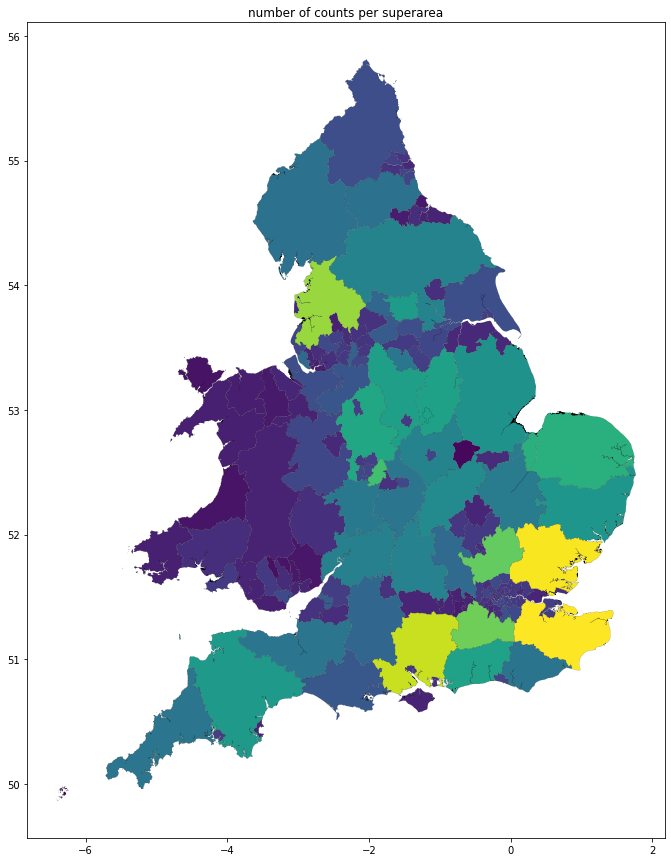

In [159]:
import matplotlib.pyplot as plt

def counts(x):
    try:return tally.loc[x]
    except:return np.nan

areas['counts'] = areas[code].map(counts)
# areas['counts'] = areas['counts']/max(areas['counts'])

plt.figure(figsize=(10,15))
# plt.rcParams['figure.figsize'] = [20, 15]
areas.plot(column='counts',cmap='viridis',edgecolor='k',linewidth=0.1)
plt.title('number of counts per superarea')
# plt.legend()
plt.savefig('flatdb/'+areatype+'/counts.png')
# plt.show()

In [146]:
# !conda install -c conda-forge descartes --yes
